# Notebook Take 3

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_rows = 999

In [3]:
# Reading in data
years = [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
         2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
dfs = []
for year in years:
    df = pd.read_csv(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{year}.csv')
    df['year'] = year
    dfs.append(df)
match_df = pd.concat(dfs)

## Data Exploration

In [4]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101396 entries, 0 to 1999
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          101396 non-null  object 
 1   tourney_name        101396 non-null  object 
 2   surface             101396 non-null  object 
 3   draw_size           101396 non-null  int64  
 4   tourney_level       101396 non-null  object 
 5   tourney_date        101396 non-null  int64  
 6   match_num           101396 non-null  int64  
 7   winner_id           101396 non-null  int64  
 8   winner_seed         41057 non-null   object 
 9   winner_entry        12307 non-null   object 
 10  winner_name         101396 non-null  object 
 11  winner_hand         101387 non-null  object 
 12  winner_ht           99101 non-null   float64
 13  winner_ioc          101396 non-null  object 
 14  winner_age          101393 non-null  float64
 15  loser_id            101396 non-null 

## Data Cleaning

### Dropping initial unecessary columns

In [5]:
# Tournament id is not going to be helpful with overall predictions but could be for individual tournaments
# Country of origin not needed
# winner_entry and seed are basically same thing so only need one
# score not needed if we know who already won
# hand not really necessary?
match_df = match_df.drop(columns = ['tourney_id', 'tourney_name', 'tourney_level', 'winner_ioc', 'loser_ioc',
                                   'match_num', 'winner_entry', 'loser_entry', 'score', 'winner_hand', 'loser_hand'])

### Dealing with Nan's

We are going to start with winner and loser seed. We are assuming nan values are players that are not seeded at tournaments

In [6]:
match_df['winner_seed'].unique()

array([nan, 8.0, 5.0, 6.0, 2.0, 3.0, 7.0, 1.0, 4.0, 16.0, 13.0, 12.0,
       14.0, 10.0, 11.0, 9.0, 15.0, 31.0, 18.0, 23.0, 25.0, 29.0, 21.0,
       28.0, 22.0, 26.0, 24.0, 17.0, 32.0, 30.0, 20.0, 27.0, 19.0, 33.0,
       35.0, '1', '2', '3', '6', '7', '8', '4', '5', '25', '17', '16',
       '19', '31', 'WC', 'Q', '23', '14', '10', '18', '28', '32', '11',
       '15', '20', '26', '27', '24', '9', '13', '12', '33', '29', '30',
       '21', '22', 'LL'], dtype=object)

We are replacing nulls with 0's because they do not have a seed. We are also doing this for lucky loser (LL) and Wild Card as 0's as well since these players are not seeded.

In [7]:
match_df['winner_seed'] = match_df['winner_seed'].replace(np.nan, '0').replace('WC', '0').replace(
'LL', '0').replace('Q', '0')

In [8]:
# Replacing loser nulls
match_df['loser_seed'] = match_df['loser_seed'].replace(np.nan, '0').replace('WC', '0').replace(
'LL', '0').replace('Q', '0')

For the nulls in winner_ht and loser_ht, we are going to replace them with mode. Most ATP players are about 6' 1" or about 185 cm.

In [9]:
match_df['winner_ht'].unique()

array([193., 198., 190., 178., 185., 173., 175., 188., 180., 183., 196.,
       170., 201.,  nan, 203., 165., 160., 168., 174., 208., 206., 191.,
       182., 181., 194., 172., 189., 176., 186., 211., 163.])

In [10]:
match_df['winner_ht'].mode()

0    185.0
dtype: float64

In [11]:
match_df['winner_ht'].fillna(match_df['winner_ht'].mode()[0], inplace = True)

In [12]:
match_df['loser_ht'].fillna(match_df['winner_ht'].mode()[0], inplace = True)

Winner_age and loser_age both have one null each. We are just going to fill them with the mode of ages for simplicity.

In [13]:
match_df['winner_age'].fillna(match_df['winner_age'].mode()[0], inplace = True)

In [14]:
match_df['loser_age'].fillna(match_df['winner_age'].mode()[0], inplace = True)

In [15]:
print(match_df['winner_age'].mode())
print(match_df['loser_age'].mode())

0    24.7
dtype: float64
0    26.0
dtype: float64


We are going to drop null values for game data. We fill it would be inaccurate to try and fill matches with game data based on measures of central tendency.

In [16]:
match_df = match_df.dropna()

In [17]:
len(match_df)

87133

### Converting Datatypes to Numeric
We do not have any nulls now. To compare our columns and make models in the future, we need to get our categorical columns to become numeric. The first columns we are going to change is Surface. Surface has 3 columns, so we are going to encode it.

In [18]:
match_df["surface"] = match_df["surface"].astype('category')
match_df.dtypes
match_df["surface_cat"] = match_df["surface"].cat.codes

Now, since we have surface_cats as an int, we no longer need 'surface'

In [19]:
match_df = match_df.drop(columns = 'surface')

Next, we are going to change winner and loser seeds to integers

In [20]:
match_df['winner_seed'] = match_df['winner_seed'].astype(int)
match_df['loser_seed'] = match_df['loser_seed'].astype(int)

For our round column, we are going to remove 'R' from values such as 'R32'. We are also going to drop 'Er', 'BR' which stand for bye and bye round. We are also going to get rid of matches with 'RR'. This stands for round robin and these matches typically do not affect rankings and are uneeded.

In [21]:
match_df['round'].value_counts()

R32     31174
R16     16370
R64     14440
R128     8690
QF       8223
SF       4200
F        2144
RR       1858
ER         32
BR          2
Name: round, dtype: int64

In [22]:
match_df = match_df.loc[match_df['round'] != 'RR']
match_df = match_df.loc[match_df['round'] != 'BR']
match_df = match_df.loc[match_df['round'] != 'ER']

In [23]:
match_df['round'] = match_df['round'].str.replace('R', '')

In [24]:
match_df['round'].unique()

array(['32', '16', 'QF', 'SF', 'F', '128', '64'], dtype=object)

The last thing we are doing for round is replacing QF, F, and SF with the number of players in those rounds.

In [25]:
match_df['round'] = match_df['round'].str.replace('QF', '8').replace('SF', '4').replace('F', '2')

In [26]:
match_df['round'] = match_df['round'].astype(int)

In [27]:
match_df = match_df.reset_index(drop=True)

## Creating fav_win  target column

This column will allow us to see if the favorite won the match or not. This will be our target columns for when we begin modelling.

In [28]:
winners_r = match_df['winner_rank']
losers_r = match_df['loser_rank']

In [29]:
favorites = []
for i in list(range(0, 85241)):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Tru

In [30]:
match_df['fav_win'] = favorites

In [31]:
match_df['fav_win'].value_counts()

True     55167
False    30074
Name: fav_win, dtype: int64

### Aggregate player stats
In order for our model to not have target/data leakage, we are changing the columns to describe their career averages (career stats limited to results within this data's timeframe). Each row will still represent a match with two competitors, but the other columns describing matchplay will not be specific to that individual match, therefore the model should not be using future data to predict future results.

In [32]:
match_df['tourney_date'] = pd.to_datetime(match_df['tourney_date'], format='%Y%m%d')

In [33]:
match_df['prev_year'] = match_df['tourney_date'].dt.year - 1

In [34]:
match_dfW = match_df.groupby(['winner_id', 'year', 'surface_cat']).mean()[['w_df',             
'w_svpt',             
   'w_1stIn',            
   'w_1stWon',           
   'w_2ndWon',           
'w_SvGms',            
  'w_bpSaved',          
  'w_bpFaced',
                                                'w_ace'
    ]]

In [35]:
match_dfL = match_df.groupby(['loser_id', 'year', 'surface_cat']).mean()[['l_ace',              
  'l_df',               
  'l_svpt',             
  'l_1stIn',            
 'l_1stWon',           
  'l_2ndWon',           
  'l_SvGms',            
 'l_bpSaved',          
  'l_bpFaced',
    ]]

In [36]:
match_df = match_df.merge(match_dfW, 
              left_on = ['winner_id', 'prev_year', 'surface_cat'], 
              right_on = ['winner_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_winner'),
              how = 'left')

In [37]:
match_df = match_df.merge(match_dfL, 
              left_on = ['loser_id', 'prev_year', 'surface_cat'], 
              right_on = ['loser_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_loser'),
              how = 'left')

In [38]:
match_df = match_df.drop(columns = ['w_ace_match',
       'w_df_match', 'w_svpt_match', 'w_1stIn_match', 'w_1stWon_match',
       'w_2ndWon_match', 'w_SvGms_match', 'w_bpSaved_match', 'w_bpFaced_match',
       'l_ace_match', 'l_df_match', 'l_svpt_match', 'l_1stIn_match',
       'l_1stWon_match', 'l_2ndWon_match', 'l_SvGms_match', 'l_bpSaved_match',
       'l_bpFaced_match', ])

In [39]:
match_df['year'].unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int64)

## Differences
In order for us to engineer the data in terms of favorite, which will allow our model to have an easily identifiable target, we have to include a column that outputs boolean True or False to whether or not the favorite won. This is calculated by looking at player rankings going into any individual match, which was provided in the original dataset.

In [40]:
favorites = []
for i in list(range(0, 85241)):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Tru

In [41]:
match_df['fav_win'] = favorites

In [42]:
match_df.columns

Index(['draw_size', 'tourney_date', 'winner_id', 'winner_seed', 'winner_name',
       'winner_ht', 'winner_age', 'loser_id', 'loser_seed', 'loser_name',
       'loser_ht', 'loser_age', 'best_of', 'round', 'minutes', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points', 'year',
       'surface_cat', 'fav_win', 'prev_year', 'w_df_winner', 'w_svpt_winner',
       'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser'],
      dtype='object')

In [43]:
match_df = match_df.drop(columns = ['winner_seed', 'loser_seed', 'winner_rank_points', 'loser_rank_points', 'minutes'])

In [44]:
fav_win_T = match_df.loc[match_df['fav_win'] == True]

In [45]:
fav_win_T['fav_rank_diff'] = fav_win_T['winner_rank'] - fav_win_T['loser_rank']
fav_win_T['fav_bpFaced_diff'] = fav_win_T['w_bpFaced_winner'] - fav_win_T['l_bpFaced_loser']
fav_win_T['fav_bpSaved_diff'] = fav_win_T['w_bpSaved_winner'] - fav_win_T['l_bpSaved_loser']
fav_win_T['fav_SvGms_diff'] = fav_win_T['w_SvGms_winner'] - fav_win_T['l_SvGms_loser']
fav_win_T['fav_2ndWon_diff'] = fav_win_T['w_2ndWon_winner'] - fav_win_T['l_2ndWon_loser']
fav_win_T['fav_1stWon_diff'] = fav_win_T['w_1stWon_winner'] - fav_win_T['l_1stWon_loser']
fav_win_T['fav_1stIn_diff'] = fav_win_T['w_1stIn_winner'] - fav_win_T['l_1stIn_loser']
fav_win_T['fav_svpt_diff'] = fav_win_T['w_svpt_winner'] - fav_win_T['l_svpt_loser']
fav_win_T['fav_df_diff'] = fav_win_T['w_df_winner'] - fav_win_T['l_df_loser']
fav_win_T['fav_ace_diff'] = fav_win_T['w_ace_winner'] - fav_win_T['l_ace_loser']
fav_win_T['fav_age_diff'] = fav_win_T['winner_age'] - fav_win_T['loser_age']
fav_win_T['fav_ht_diff'] = fav_win_T['winner_ht'] - fav_win_T['loser_ht']

In [46]:
# dropping not diff columns
fav_win_T = fav_win_T.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age'])

In [47]:
fav_win_F = match_df.loc[match_df['fav_win'] == False]

In [48]:
fav_win_F['fav_rank_diff'] =fav_win_F['loser_rank'] - fav_win_F['winner_rank'] 
fav_win_F['fav_bpFaced_diff'] =fav_win_F['l_bpFaced_loser'] - fav_win_F['w_bpFaced_winner']  
fav_win_F['fav_bpSaved_diff'] =fav_win_F['l_bpSaved_loser'] - fav_win_F['w_bpSaved_winner']  
fav_win_F['fav_SvGms_diff'] =fav_win_F['l_SvGms_loser'] - fav_win_F['w_SvGms_winner'] 
fav_win_F['fav_2ndWon_diff'] =fav_win_F['l_2ndWon_loser'] - fav_win_F['w_2ndWon_winner']  
fav_win_F['fav_1stWon_diff'] =fav_win_F['l_1stWon_loser'] - fav_win_F['w_1stWon_winner']  
fav_win_F['fav_1stIn_diff'] =fav_win_F['l_1stIn_loser'] - fav_win_F['w_1stIn_winner'] 
fav_win_F['fav_svpt_diff'] =fav_win_F['l_svpt_loser'] - fav_win_F['w_svpt_winner'] 
fav_win_F['fav_df_diff'] =fav_win_F['l_df_loser'] - fav_win_F['w_df_winner']  
fav_win_F['fav_ace_diff'] =fav_win_F['l_ace_loser'] - fav_win_F['w_ace_winner']  
fav_win_F['fav_age_diff'] =fav_win_F['loser_age'] - fav_win_F['winner_age'] 
fav_win_F['fav_ht_diff'] =fav_win_F['loser_ht'] - fav_win_F['winner_ht'] 

In [49]:
fav_win_F = fav_win_F.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age'])

In [50]:
agg_df = pd.concat([fav_win_T, fav_win_F]).sort_values(by = 'tourney_date')

In [51]:
agg_df.head()

,draw_size,tourney_date,winner_id,winner_name,loser_id,loser_name,best_of,round,winner_rank,loser_rank,...,fav_bpSaved_diff,fav_SvGms_diff,fav_2ndWon_diff,fav_1stWon_diff,fav_1stIn_diff,fav_svpt_diff,fav_df_diff,fav_ace_diff,fav_age_diff,fav_ht_diff
0,32,1991-01-07,101142,Emilio Sanchez,101746,Renzo Furlan,3,32,9.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
59,32,1991-01-07,101098,Guy Forget,101529,Michael Stich,3,2,16.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,-3.0
58,32,1991-01-07,101529,Michael Stich,101320,Magnus Gustafsson,3,4,38.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,-8.0
53,32,1991-01-07,101196,Derrick Rostagno,101073,Martin Jaite,3,8,49.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-7.0
50,32,1991-01-07,101529,Michael Stich,101084,Jakob Hlasek,3,16,38.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,-5.0


## Model-less Baseline

Let's see how we can predict future matches prior to making any models

In [52]:
agg_df['fav_win'].value_counts()

True     55167
False    30074
Name: fav_win, dtype: int64

In [53]:
55166 / len(agg_df['fav_win'])

0.6471768280522284

Our model-less baseline is about 65% accurate if you were to predict that the favorite won every time.

## Splitting Data
Seperating our data into a train-test split including a hold out set of the past two years for our final model to test and be evaluated on.

In [54]:
test_df = agg_df.loc[agg_df['year'] >= 2021]

In [55]:
X = agg_df.drop(columns='fav_win')
y = agg_df['fav_win']
# Preparing our hold out data for train test split
X_cols = X.columns
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=2022, test_size=len(test_df), shuffle = False)
X_test, X_hold, y_test, y_hold =train_test_split(X_test, y_test, test_size=500, shuffle=False)

In [56]:
agg_df['fav_win'].value_counts()

True     55167
False    30074
Name: fav_win, dtype: int64

In [57]:
X_train = X_train.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year',
                                 'winner_rank', 'loser_rank', 'year'])
X_test = X_test.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year',
                               'winner_rank', 'loser_rank', 'year'])
X_hold = X_hold.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year', 
                                'winner_rank', 'loser_rank', 'year'])

## Function

In [58]:
def evaluate(model,Xtr,Xte,ytr,yte):
    train_preds = model.predict(Xtr)
    test_preds = model.predict(Xte)

    train_probas = model.predict_proba(Xtr)[:,1]
    test_probas = model.predict_proba(Xte)[:,1]
    
    plot_confusion_matrix(model,Xte,yte)
    
    plot_roc_curve(model,Xte,yte)
    
    print(f"Train Accuracy: {accuracy_score(ytr,train_preds):.4f}")
    print(f"Train F1: {f1_score(ytr,train_preds):.4f}")
    print(f"Train Precision: {precision_score(ytr,train_preds):.4f}")
    print(f"Train Recall: {recall_score(ytr,train_preds):.4f}")
    print(f"Train ROC-AUC: {roc_auc_score(ytr,train_probas):.4f}")
    print('*'*20)
    print(f"Test Accuracy: {accuracy_score(yte,test_preds):.4f}")
    print(f"Test F1: {f1_score(yte,test_preds):.4f}")
    print(f"Test Precision: {precision_score(yte,test_preds):.4f}")
    print(f"Test Recall: {recall_score(yte,test_preds):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(yte,test_probas):.4f}")

## LOGREG MODEL 1

In [59]:
si = SimpleImputer()

si.fit(X_train)

X_train_im = si.transform(X_train)
X_test_im = si.transform(X_test)
X_hold_im = si.transform(X_hold)

In [60]:
scaler = StandardScaler()

scaler.fit(X_train_im)

X_train_sc = scaler.transform(X_train_im)
X_test_sc = scaler.transform(X_test_im)
X_hold_sc = scaler.transform(X_hold_im)

In [61]:
logreg = LogisticRegression(penalty = 'l2', random_state = 42, C = .5)

logreg.fit(X_train_sc,y_train)

LogisticRegression(C=0.5, random_state=42)

Train Accuracy: 0.8739
Train F1: 0.9091
Train Precision: 0.8527
Train Recall: 0.9737
Train ROC-AUC: 0.9509
********************
Test Accuracy: 0.8628
Test F1: 0.8995
Test Precision: 0.8339
Test Recall: 0.9764
Test ROC-AUC: 0.9498


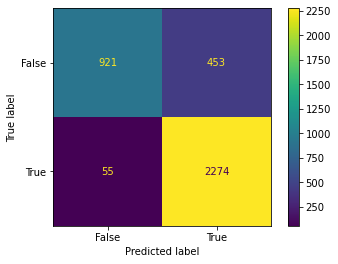

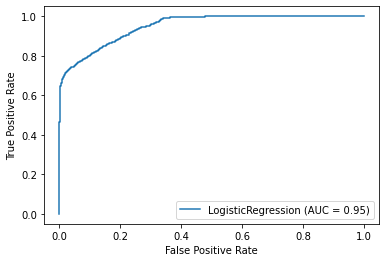

In [62]:
evaluate(logreg,X_train_sc,X_test_sc,y_train,y_test)

## Model 2: Decision Tree

In [63]:
tree = DecisionTreeClassifier(random_state = 42,max_depth = 5)

tree.fit(X_train_im, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Train Accuracy: 0.8622
Train F1: 0.9023
Train Precision: 0.8349
Train Recall: 0.9816
Train ROC-AUC: 0.9383
********************
Test Accuracy: 0.8445
Test F1: 0.8879
Test Precision: 0.8123
Test Recall: 0.9790
Test ROC-AUC: 0.9324


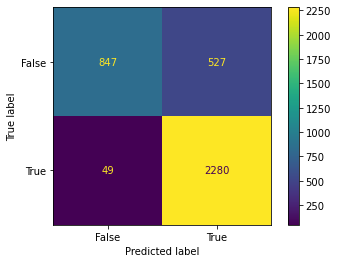

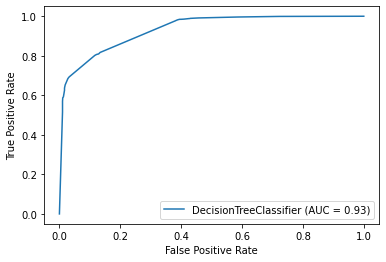

In [64]:
evaluate(tree,X_train_im,X_test_im,y_train,y_test)

## Model 3: Naive Bayes

In [65]:
clf_nb = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('naive_bayes', GaussianNB()),
])

clf_nb.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('naive_bayes', GaussianNB())])

Train Accuracy: 0.8200
Train F1: 0.8694
Train Precision: 0.8204
Train Recall: 0.9248
Train ROC-AUC: 0.8787
********************
Test Accuracy: 0.7942
Test F1: 0.8468
Test Precision: 0.7962
Test Recall: 0.9043
Test ROC-AUC: 0.8721


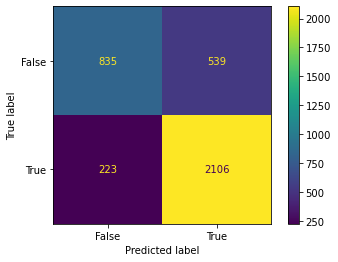

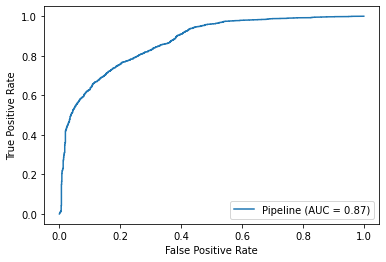

In [66]:
evaluate(clf_nb,X_train_im,X_test_im,y_train,y_test)

## Model 4: Random Forest

In [67]:
# smote = SMOTE(random_state=42)
# X_train_im, y_train = smote.fit_resample(X_train_im,y_train)

In [68]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42,max_depth = 10)),
])

clf_rf.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [69]:
cross_validate(clf_rf,X_train_im,y_train,scoring='accuracy',return_train_score = True)

KeyboardInterrupt: 

In [ ]:
evaluate(clf_rf,X_train_im,X_test_im,y_train,y_test)

## Model 5: Random Forest with Grid Search

In [ ]:
# param_grid = {
#     "random forest__criterion":['gini','entropy'],
#     "random forest__max_depth": [1,2,3,4,5,10,15],
#     "random forest__min_samples_leaf": [1,2,5,10,12,15],
#     "random forest__min_samples_split": [2,4,6,8]
# }

In [ ]:
# clf_rf = Pipeline(steps = [
#     ('scaler', StandardScaler()),
#     ('random forest', RandomForestClassifier(random_state=42)),
# ])

# clf_rf.fit(X_train_im,y_train)

In [ ]:
# gs = GridSearchCV(clf_rf,param_grid,cv = 5,scoring = 'accuracy')

# gs.fit(X_train_im,y_train)

In [ ]:
# gs.best_params_

In [ ]:
# gs.best_score_

In [ ]:
# evaluate(gs.best_estimator_,X_train_im,X_test_im,y_train,y_test)

## Experimenting with Logistic Regressions

For our baseline models, we found our logreg model to have the highest test score and the least discrepancy in value between its test and train values. Therefore, we are going to continue working with logregs and see if we can make the model more accurate as well as reduce multicollinearity and overfitting. I'm going to experiment with dropping different columns to see if we can reduce multicollinearity. We also want to see if we can reduce our false positives.

In [70]:
X_train.columns

Index(['draw_size', 'best_of', 'round', 'surface_cat', 'fav_rank_diff',
       'fav_bpFaced_diff', 'fav_bpSaved_diff', 'fav_SvGms_diff',
       'fav_2ndWon_diff', 'fav_1stWon_diff', 'fav_1stIn_diff', 'fav_svpt_diff',
       'fav_df_diff', 'fav_ace_diff', 'fav_age_diff', 'fav_ht_diff'],
      dtype='object')

In [71]:
X_train.corr()

,draw_size,best_of,round,surface_cat,fav_rank_diff,fav_bpFaced_diff,fav_bpSaved_diff,fav_SvGms_diff,fav_2ndWon_diff,fav_1stWon_diff,fav_1stIn_diff,fav_svpt_diff,fav_df_diff,fav_ace_diff,fav_age_diff,fav_ht_diff
draw_size,1.000000,0.862924,0.690057,0.177308,0.042068,-0.046717,-0.034381,0.003862,0.010288,0.019115,-0.004643,-0.012667,-0.019220,0.022123,0.002334,0.012403
best_of,0.862924,1.000000,0.582103,0.083306,0.011817,-0.048543,-0.034824,0.002965,0.008661,0.021236,-0.003993,-0.013129,-0.020389,0.025840,0.004854,0.010796
round,0.690057,0.582103,1.000000,0.126548,-0.056824,-0.003863,0.000469,0.010573,0.017354,0.009743,0.004592,0.009438,0.005813,0.012367,0.013443,0.017155
surface_cat,0.177308,0.083306,0.126548,1.000000,-0.000345,-0.025661,-0.024048,-0.013066,-0.007568,-0.005688,-0.015522,-0.022162,-0.016935,0.009380,0.012048,0.007894
fav_rank_diff,0.042068,0.011817,-0.056824,-0.000345,1.000000,0.100969,0.055624,-0.049469,-0.073887,-0.085911,-0.030036,-0.020977,0.042483,-0.063426,-0.066359,-0.000827
fav_bpFaced_diff,-0.046717,-0.048543,-0.003863,-0.025661,0.100969,1.000000,0.892231,0.275039,0.021927,-0.005337,0.384163,0.504752,0.403860,-0.286812,0.012067,-0.134478
fav_bpSaved_diff,-0.034381,-0.034824,0.000469,-0.024048,0.055624,0.892231,1.000000,0.338179,0.190057,0.197966,0.473815,0.575241,0.354569,-0.144593,0.004590,-0.092111
fav_SvGms_diff,0.003862,0.002965,0.010573,-0.013066,-0.049469,0.275039,0.338179,1.000000,0.700590,0.847401,0.845904,0.927098,0.321939,0.407283,0.004490,0.089875
fav_2ndWon_diff,0.010288,0.008661,0.017354,-0.007568,-0.073887,0.021927,0.190057,0.700590,1.000000,0.507459,0.369854,0.662087,0.244436,0.401550,-0.030476,0.044744
fav_1stWon_diff,0.019115,0.021236,0.009743,-0.005688,-0.085911,-0.005337,0.197966,0.847401,0.507459,1.000000,0.878145,0.787139,0.155827,0.509747,0.011448,0.173859


## Logreg 2

There appears to be a very high collinearity btwn draw_size and best_of. I don't believe this is necessary for the model. Round could also be done away with. Also, other than ace_diff, ht does not have a big correlation with any other column. To me, this means it could also possibly be removed.

In [72]:
X_train = X_train.drop(columns = ['fav_age_diff', 'fav_ht_diff', 'draw_size'])
X_test = X_test.drop(columns = ['fav_age_diff', 'fav_ht_diff', 'draw_size'])

In [73]:
X_hold = X_hold.drop(columns = ['fav_age_diff', 'fav_ht_diff', 'draw_size'])

In [74]:
si.fit(X_train)

X_train_im = si.transform(X_train)
X_test_im = si.transform(X_test)

In [75]:
scaler.fit(X_train_im)

X_train_sc = scaler.transform(X_train_im)
X_test_sc = scaler.transform(X_test_im)

In [76]:
logreg.fit(X_train_sc,y_train)

LogisticRegression(C=0.5, random_state=42)

Train Accuracy: 0.8738
Train F1: 0.9091
Train Precision: 0.8527
Train Recall: 0.9734
Train ROC-AUC: 0.9506
********************
Test Accuracy: 0.8634
Test F1: 0.8998
Test Precision: 0.8347
Test Recall: 0.9760
Test ROC-AUC: 0.9480


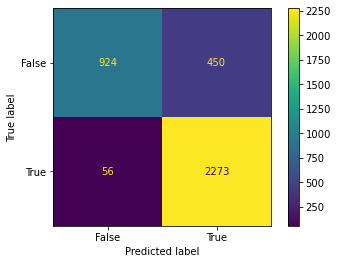

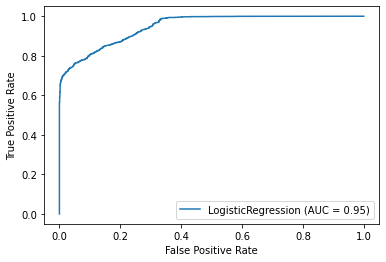

In [77]:
evaluate(logreg,X_train_sc,X_test_sc,y_train,y_test)

## Logreg 3

In [78]:
agg_df.corr()

,draw_size,winner_id,loser_id,best_of,round,winner_rank,loser_rank,year,surface_cat,fav_win,...,fav_bpSaved_diff,fav_SvGms_diff,fav_2ndWon_diff,fav_1stWon_diff,fav_1stIn_diff,fav_svpt_diff,fav_df_diff,fav_ace_diff,fav_age_diff,fav_ht_diff
draw_size,1.000000,0.027238,0.032366,0.854934,0.689856,-0.104603,-0.069290,0.114659,0.181177,0.043949,...,-0.032984,0.003235,0.009119,0.018483,-0.004829,-0.012980,-0.018879,0.020978,0.001855,0.013233
winner_id,0.027238,1.000000,0.266475,0.006151,0.008212,0.022517,-0.019564,0.356649,0.048541,-0.034274,...,0.007805,-0.007674,-0.011962,-0.013692,-0.008846,-0.006278,0.011622,-0.013644,-0.016860,0.007513
loser_id,0.032366,0.266475,1.000000,0.013540,0.008486,-0.009923,0.035669,0.343158,0.047192,0.015198,...,-0.010694,-0.008047,-0.007802,-0.008287,-0.012974,-0.013056,0.008481,0.003944,0.081193,0.010518
best_of,0.854934,0.006151,0.013540,1.000000,0.581649,-0.068353,-0.026671,0.080389,0.083476,0.049138,...,-0.034523,0.002779,0.008524,0.021617,-0.003711,-0.013147,-0.022020,0.025631,0.003547,0.010877
round,0.689856,0.008212,0.008486,0.581649,1.000000,0.089988,0.085108,0.054950,0.127608,0.002740,...,0.002956,0.009339,0.016302,0.009182,0.004929,0.009368,0.005332,0.009767,0.011346,0.016086
winner_rank,-0.104603,0.022517,-0.009923,-0.068353,0.089988,1.000000,0.121122,-0.057207,-0.028987,-0.432429,...,0.244088,-0.013897,-0.112833,-0.148747,0.031586,0.082086,0.154928,-0.155820,0.050728,-0.034872
loser_rank,-0.069290,-0.019564,0.035669,-0.026671,0.085108,0.121122,1.000000,-0.058317,-0.009643,0.303618,...,-0.133812,0.050326,0.128861,0.143670,0.021520,-0.004579,-0.095686,0.105515,0.059206,0.001868
year,0.114659,0.356649,0.343158,0.080389,0.054950,-0.057207,-0.058317,1.000000,0.189053,0.007238,...,-0.023207,-0.009758,-0.026158,-0.006004,-0.013245,-0.024163,-0.005969,0.011193,0.034045,0.023246
surface_cat,0.181177,0.048541,0.047192,0.083476,0.127608,-0.028987,-0.009643,0.189053,1.000000,0.018073,...,-0.022610,-0.012983,-0.009058,-0.004508,-0.014264,-0.021095,-0.016831,0.010667,0.008496,0.009811
fav_win,0.043949,-0.034274,0.015198,0.049138,0.002740,-0.432429,0.303618,0.007238,0.018073,1.000000,...,-0.469860,0.010141,0.246676,0.288933,-0.072604,-0.167908,-0.302749,0.280411,-0.043430,0.041219


If we look at correlations in our dataframe, we saw the highest correlations with serve. Specifaclly, we see a high negative correlation on break points faced. The more break points someone faces, the less likely they are to win. We are going to run our next logreg on just game stats.

In [79]:
X_train.columns

Index(['best_of', 'round', 'surface_cat', 'fav_rank_diff', 'fav_bpFaced_diff',
       'fav_bpSaved_diff', 'fav_SvGms_diff', 'fav_2ndWon_diff',
       'fav_1stWon_diff', 'fav_1stIn_diff', 'fav_svpt_diff', 'fav_df_diff',
       'fav_ace_diff'],
      dtype='object')

In [80]:
X_train = X_train.drop(columns = ['best_of', 'round', 'surface_cat', 'fav_rank_diff'])
X_test = X_test.drop(columns = ['best_of', 'round', 'surface_cat', 'fav_rank_diff'])

In [81]:
X_hold = X_hold.drop(columns = ['best_of', 'round', 'surface_cat', 'fav_rank_diff']) 

In [82]:
si.fit(X_train)

X_train_im = si.transform(X_train)
X_test_im = si.transform(X_test)
X_hold_im = si.transform(X_hold)

In [83]:
scaler.fit(X_train_im)

X_train_sc = scaler.transform(X_train_im)
X_test_sc = scaler.transform(X_test_im)
X_hold_sc = scaler.transform(X_hold_im)

In [84]:
logreg.fit(X_train_sc,y_train)

LogisticRegression(C=0.5, random_state=42)

Train Accuracy: 0.8740
Train F1: 0.9092
Train Precision: 0.8526
Train Recall: 0.9739
Train ROC-AUC: 0.9446
********************
Test Accuracy: 0.8642
Test F1: 0.9005
Test Precision: 0.8352
Test Recall: 0.9768
Test ROC-AUC: 0.9416


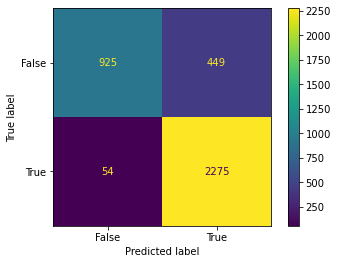

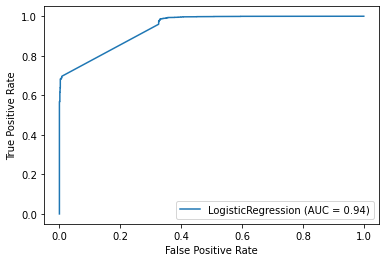

In [85]:
evaluate(logreg,X_train_sc,X_test_sc,y_train,y_test)

## Testing on Holdout Set
### #Panicking

In [86]:
holdout_explore = pd.DataFrame(y_hold)

In [87]:
holdout_explore['Predicted Probability'] = logreg.predict_proba(X_hold_sc)[:,1]

In [88]:
holdout_explore['Prediction'] = logreg.predict(X_hold_sc)

In [89]:
holdout_explore

,fav_win,Predicted Probability,Prediction
84740,False,0.000071,False
84741,False,0.000942,False
84738,True,0.998266,True
84737,True,0.999507,True
84777,True,0.984739,True
84748,True,0.970904,True
84797,True,0.791463,True
84792,True,0.704323,True
84789,True,0.998034,True
84788,True,0.966250,True


In [90]:
wrong_preds = holdout_explore.loc[holdout_explore['fav_win'] != holdout_explore['Prediction']].index

In [91]:
wrong_preds

Int64Index([84753, 84791, 84784, 84794, 84795, 84782, 84779, 84778, 84768,
            84774, 84849, 84836, 84842, 84824, 84814, 84816, 84818, 84832,
            84807, 84805, 84801, 84806, 84852, 84855, 84856, 84863, 84867,
            84963, 84953, 84946, 84937, 84962, 84865, 84934, 84923, 84917,
            84904, 84903, 84902, 84901, 84900, 84899, 84860, 84881, 84883,
            84876, 84978, 85027, 85021, 84994, 85026, 85024, 85017, 85016,
            85009, 85005, 84999, 85034, 85076, 85038, 85049, 85042, 85144,
            85138, 85137, 85132, 85123, 85118, 85115, 85112, 85124, 85105,
            85150, 85152, 85159, 85163, 85212, 85228, 85230, 85233, 85202,
            85193],
           dtype='int64')

Train Accuracy: 0.8740
Train F1: 0.9092
Train Precision: 0.8526
Train Recall: 0.9739
Train ROC-AUC: 0.9446
********************
Test Accuracy: 0.8360
Test F1: 0.8812
Test Precision: 0.8064
Test Recall: 0.9712
Test ROC-AUC: 0.8989


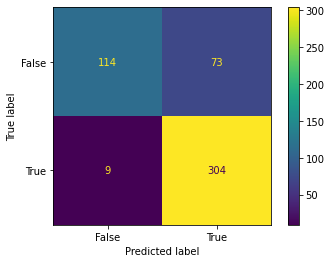

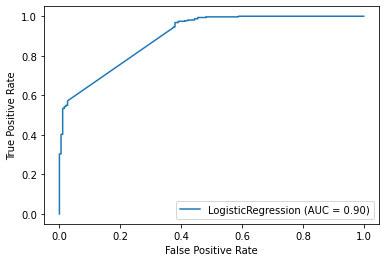

In [92]:
evaluate(logreg,X_train_sc,X_hold_sc,y_train,y_hold)

Conclusion: We are modeling beasts. With 9 columns, we can predict the winner of a match with 86% accuracy. The next step is either working with LIME or filling out a draw.

In [93]:
X_train

,fav_bpFaced_diff,fav_bpSaved_diff,fav_SvGms_diff,fav_2ndWon_diff,fav_1stWon_diff,fav_1stIn_diff,fav_svpt_diff,fav_df_diff,fav_ace_diff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
80999,-6.514620,-4.444444,-1.000000,-0.467836,-2.619883,-10.777778,-18.245614,-3.233918,2.438596
80994,0.901961,-0.862745,-3.529412,-5.294118,-15.647059,-14.647059,-22.901961,-1.627451,-4.078431
81011,1.181818,-0.409091,1.348485,1.136364,-2.696970,1.833333,3.424242,0.363636,-0.439394
81010,1.011111,-0.333333,3.511111,5.911111,6.155556,14.566667,21.600000,-0.544444,-3.877778


In [94]:
logreg.coef_

array([[-5.70123478,  3.56979617,  1.08606155,  1.45305897,  2.38820553,
        -0.11715504, -3.54922872,  0.10716387, -0.92352039]])

In [95]:
dict(zip(X_train.columns, logreg.coef_[0]))

{'fav_bpFaced_diff': -5.7012347767070715,
 'fav_bpSaved_diff': 3.569796166784168,
 'fav_SvGms_diff': 1.0860615502131736,
 'fav_2ndWon_diff': 1.4530589685091893,
 'fav_1stWon_diff': 2.3882055320207565,
 'fav_1stIn_diff': -0.11715504381362184,
 'fav_svpt_diff': -3.5492287204513566,
 'fav_df_diff': 0.10716387123195813,
 'fav_ace_diff': -0.9235203937772352}

## Probabilities

In [123]:
match_df

,draw_size,tourney_date,winner_id,winner_name,winner_ht,winner_age,loser_id,loser_name,loser_ht,loser_age,...,w_ace_winner,l_ace_loser,l_df_loser,l_svpt_loser,l_1stIn_loser,l_1stWon_loser,l_2ndWon_loser,l_SvGms_loser,l_bpSaved_loser,l_bpFaced_loser
0,32,1991-01-07,101142,Emilio Sanchez,180.0,25.6,101746,Renzo Furlan,175.0,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32,1991-01-07,101613,Malivai Washington,180.0,21.5,100587,Steve Guy,188.0,31.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,1991-01-07,101179,Jean Philippe Fleurian,185.0,25.3,101601,Brett Steven,185.0,21.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32,1991-01-07,101117,Eric Jelen,180.0,25.8,101332,Gilad Bloom,173.0,23.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,1991-01-07,101901,Chuck Adams,185.0,19.7,101735,Richard Fromberg,196.0,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85236,64,2022-08-01,106045,Denis Kudla,180.0,29.9,111581,Michael Mmoh,188.0,24.5,...,8.500000,6.000000,3.500000,75.500000,48.750000,30.750000,12.000000,11.250000,7.000000,10.750000
85237,64,2022-08-01,105173,Adrian Mannarino,183.0,34.0,105614,Bradley Klahn,190.0,31.9,...,5.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85238,64,2022-08-01,200624,Sebastian Korda,196.0,22.0,125802,Ilya Ivashka,193.0,28.4,...,6.705882,5.714286,3.285714,86.714286,51.428571,35.428571,18.285714,13.571429,5.857143,9.285714
85239,64,2022-08-01,144707,Mikael Ymer,183.0,23.8,104918,Andy Murray,190.0,35.2,...,3.200000,6.666667,3.333333,83.000000,45.583333,31.833333,18.250000,12.166667,4.500000,7.666667


In [124]:
match_df.loc[match_df['winner_name'] == 'Nick Kyrgios']

,draw_size,tourney_date,winner_id,winner_name,winner_ht,winner_age,loser_id,loser_name,loser_ht,loser_age,...,w_ace_winner,l_ace_loser,l_df_loser,l_svpt_loser,l_1stIn_loser,l_1stWon_loser,l_2ndWon_loser,l_SvGms_loser,l_bpSaved_loser,l_bpFaced_loser
64139,128,2013-05-27,106401,Nick Kyrgios,193.0,18.0,103285,Radek Stepanek,185.0,34.4,...,NaN,4.000000,3.200000,96.400000,60.200000,36.600000,17.800000,13.400000,9.200000,13.600000
65636,128,2014-01-13,106401,Nick Kyrgios,193.0,18.7,103794,Benjamin Becker,178.0,32.5,...,NaN,7.062500,3.625000,79.500000,42.875000,31.500000,16.750000,12.250000,4.562500,7.937500
66999,128,2014-06-23,106401,Nick Kyrgios,193.0,19.1,103565,Stephane Robert,185.0,34.0,...,NaN,4.000000,4.000000,98.000000,60.000000,42.000000,23.000000,16.000000,3.000000,6.000000
67034,128,2014-06-23,106401,Nick Kyrgios,193.0,19.1,104755,Richard Gasquet,185.0,28.0,...,NaN,10.000000,2.000000,91.000000,61.500000,51.000000,16.500000,16.000000,3.500000,5.500000
67052,128,2014-06-23,106401,Nick Kyrgios,193.0,19.1,106210,Jiri Vesely,198.0,20.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67061,128,2014-06-23,106401,Nick Kyrgios,193.0,19.1,104745,Rafael Nadal,185.0,28.0,...,NaN,6.000000,3.000000,119.000000,80.000000,52.000000,21.000000,17.000000,8.000000,11.000000
67384,56,2014-08-04,106401,Nick Kyrgios,193.0,19.2,105053,Santiago Giraldo,188.0,26.6,...,NaN,4.500000,2.357143,82.928571,49.928571,32.928571,16.000000,12.785714,4.142857,7.642857
67553,128,2014-08-25,106401,Nick Kyrgios,193.0,19.3,104022,Mikhail Youzhny,183.0,32.1,...,NaN,2.666667,3.200000,80.133333,46.533333,29.600000,15.800000,12.133333,4.866667,8.800000
67607,128,2014-08-25,106401,Nick Kyrgios,193.0,19.3,104312,Andreas Seppi,190.0,30.5,...,NaN,4.875000,3.062500,80.500000,47.250000,33.062500,15.250000,12.437500,4.875000,8.312500
68242,128,2015-01-19,106401,Nick Kyrgios,193.0,19.7,105643,Federico Delbonis,190.0,24.2,...,23.250000,3.833333,3.583333,82.000000,48.833333,32.750000,17.750000,12.916667,5.166667,8.333333


In [125]:
loser_stats = match_df.groupby(by=['loser_name', 'surface_cat'])[['l_df_loser', 'l_svpt_loser', 'l_ace_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser', 'loser_rank'
       ]].mean()

In [126]:
loser_stats.index.names = ['name', 'surface']

In [127]:
match_df.columns

Index(['draw_size', 'tourney_date', 'winner_id', 'winner_name', 'winner_ht',
       'winner_age', 'loser_id', 'loser_name', 'loser_ht', 'loser_age',
       'best_of', 'round', 'winner_rank', 'loser_rank', 'year', 'surface_cat',
       'fav_win', 'prev_year', 'w_df_winner', 'w_svpt_winner',
       'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser'],
      dtype='object')

In [128]:
winner_stats = match_df.groupby(by=['winner_name', 'surface_cat'])[['w_df_winner', 'w_svpt_winner',
       'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner', 'w_ace_winner', 'winner_rank']].mean()

In [129]:
winner_stats.index.names = ['name', 'surface']

In [130]:
match_df.columns

Index(['draw_size', 'tourney_date', 'winner_id', 'winner_name', 'winner_ht',
       'winner_age', 'loser_id', 'loser_name', 'loser_ht', 'loser_age',
       'best_of', 'round', 'winner_rank', 'loser_rank', 'year', 'surface_cat',
       'fav_win', 'prev_year', 'w_df_winner', 'w_svpt_winner',
       'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser'],
      dtype='object')

In [131]:
player_stats = winner_stats.join(loser_stats)

In [132]:
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3333 entries, ('Aaron Krickstein', 0) to ('Zizou Bergs', 3)
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   w_df_winner       2101 non-null   float64
 1   w_svpt_winner     2101 non-null   float64
 2   w_1stIn_winner    2101 non-null   float64
 3   w_1stWon_winner   2101 non-null   float64
 4   w_2ndWon_winner   2101 non-null   float64
 5   w_SvGms_winner    2101 non-null   float64
 6   w_bpSaved_winner  2101 non-null   float64
 7   w_bpFaced_winner  2101 non-null   float64
 8   w_ace_winner      2101 non-null   float64
 9   winner_rank       3333 non-null   float64
 10  l_df_loser        2814 non-null   float64
 11  l_svpt_loser      2814 non-null   float64
 12  l_ace_loser       2814 non-null   float64
 13  l_1stIn_loser     2814 non-null   float64
 14  l_1stWon_loser    2814 non-null   float64
 15  l_2ndWon_loser    2814 non-null   float64
 16  l_SvGm

In [133]:
player_stats['avg_bpFaced'] =(player_stats['l_bpFaced_loser'] + player_stats['w_bpFaced_winner'] ) /2
player_stats['avg_bpSaved'] =(player_stats['l_bpSaved_loser'] + player_stats['w_bpSaved_winner'] ) /2
player_stats['avg_Svgms'] =(player_stats['l_SvGms_loser'] + player_stats['w_SvGms_winner'] ) /2
player_stats['avg_2ndWon'] =(player_stats['l_2ndWon_loser'] + player_stats['w_2ndWon_winner']  ) /2
player_stats['avg_1stWon'] =(player_stats['l_1stWon_loser'] + player_stats['w_1stWon_winner'] ) /2
player_stats['avg_1stin'] =(player_stats['l_1stIn_loser'] + player_stats['w_1stIn_winner'] ) /2
player_stats['avg_svpt'] =(player_stats['l_svpt_loser'] + player_stats['w_svpt_winner']) /2
player_stats['avg_df'] =(player_stats['l_df_loser'] + player_stats['w_df_winner']  ) /2
player_stats['avg_ace'] =(player_stats['l_ace_loser'] + player_stats['w_ace_winner'] )/2
player_stats['avg_rank'] =(player_stats['loser_rank'] + player_stats['winner_rank'] )/2

In [134]:
player_stats.columns

Index(['w_df_winner', 'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner',
       'w_2ndWon_winner', 'w_SvGms_winner', 'w_bpSaved_winner',
       'w_bpFaced_winner', 'w_ace_winner', 'winner_rank', 'l_df_loser',
       'l_svpt_loser', 'l_ace_loser', 'l_1stIn_loser', 'l_1stWon_loser',
       'l_2ndWon_loser', 'l_SvGms_loser', 'l_bpSaved_loser', 'l_bpFaced_loser',
       'loser_rank', 'avg_bpFaced', 'avg_bpSaved', 'avg_Svgms', 'avg_2ndWon',
       'avg_1stWon', 'avg_1stin', 'avg_svpt', 'avg_df', 'avg_ace', 'avg_rank'],
      dtype='object')

In [135]:
player_stats = player_stats.drop(columns = ['w_df_winner', 'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner',
       'w_2ndWon_winner', 'w_SvGms_winner', 'w_bpSaved_winner',
       'w_bpFaced_winner', 'w_ace_winner', 'l_df_loser', 'l_svpt_loser',
       'l_ace_loser', 'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser',
       'l_SvGms_loser', 'l_bpSaved_loser', 'l_bpFaced_loser'])

In [136]:
player_stats.columns

Index(['winner_rank', 'loser_rank', 'avg_bpFaced', 'avg_bpSaved', 'avg_Svgms',
       'avg_2ndWon', 'avg_1stWon', 'avg_1stin', 'avg_svpt', 'avg_df',
       'avg_ace', 'avg_rank'],
      dtype='object')

In [174]:
player_stats = player_stats.reset_index()

In [178]:
fav_test = player_stats.loc[(player_stats['name'] == 'Nick Kyrgios') & (player_stats['surface'] == 3)]

In [179]:
unfav_test = player_stats.loc[(player_stats['name'] == 'Yoshihito Nishioka') & (player_stats['surface'] == 3)]

In [180]:
fav_test

,name,surface,winner_rank,loser_rank,avg_bpFaced,avg_bpSaved,avg_Svgms,avg_2ndWon,avg_1stWon,avg_1stin,avg_svpt,avg_df,avg_ace,avg_rank
2370,Nick Kyrgios,3,39.617391,45.241379,5.298528,3.40902,14.295493,16.114154,44.672836,58.542812,89.704921,3.609674,15.639525,42.429385


In [234]:
comb_test = pd.concat([fav_test, unfav_test])
comb_test

,name,surface,winner_rank,loser_rank,avg_bpFaced,avg_bpSaved,avg_Svgms,avg_2ndWon,avg_1stWon,avg_1stin,avg_svpt,avg_df,avg_ace,avg_rank
2370,Nick Kyrgios,3,39.617391,45.241379,5.298528,3.409020,14.295493,16.114154,44.672836,58.542812,89.704921,3.609674,15.639525,42.429385
3309,Yoshihito Nishioka,3,102.000000,99.924242,7.073449,4.007152,11.400212,13.844679,30.809908,48.376528,74.116730,1.746938,1.472782,100.962121


In [227]:
avg_cols = [c for c in comb_test.columns if 'avg' in c][:-1]

In [228]:
avg_cols

['avg_bpFaced',
 'avg_bpSaved',
 'avg_Svgms',
 'avg_2ndWon',
 'avg_1stWon',
 'avg_1stin',
 'avg_svpt',
 'avg_df',
 'avg_ace']

In [229]:
players = comb_test[avg_cols].index

In [230]:
comb_transp = comb_test[avg_cols].T
comb_transp['diff'] = comb_transp[players[0]] - comb_transp[players[1]]


In [231]:
test_row = comb_transp.T.reset_index().iloc[[2]][avg_cols]
test_row

,avg_bpFaced,avg_bpSaved,avg_Svgms,avg_2ndWon,avg_1stWon,avg_1stin,avg_svpt,avg_df,avg_ace
2,-1.77492,-0.598133,2.895281,2.269475,13.862928,10.166284,15.588191,1.862736,14.166742


In [232]:
test_row_sc = scaler.transform(test_row)
logreg.predict(test_row_sc)

array([ True])

In [236]:
logreg.predict_proba(test_row_sc)[:,1]

array([0.53153776])

In [139]:
def build_data(fav_name, unfav_name, surface, stats_data=player_stats):
    fav_data = stats_data.loc[() & ()]
    
    unfav_data = player_stats.loc[[unfav_name]]
    
    predict_proba
    
    
    surface = surface
    
    return fav_data, unfav_name, surface

In [140]:
build_data('Nick Kyrgios', 'Yoshihito Nishioka', 1)

(                      winner_rank  loser_rank  avg_bpFaced  avg_bpSaved  \
 name         surface                                                      
 Nick Kyrgios 1          42.560000   51.388889     6.152530     3.860119   
              2          55.100000   43.000000     5.831633     4.016234   
              3          39.617391   45.241379     5.298528     3.409020   
 
                       avg_Svgms  avg_2ndWon  avg_1stWon  avg_1stin   avg_svpt  \
 name         surface                                                            
 Nick Kyrgios 1        12.902158   15.490327   39.470982  54.561384  84.306920   
              2        15.627551   17.922078   47.075139  63.550557  92.979592   
              3        14.295493   16.114154   44.672836  58.542812  89.704921   
 
                         avg_df    avg_ace   avg_rank  
 name         surface                                  
 Nick Kyrgios 1        3.328125   8.914807  46.974444  
              2        3.297774  18.21

In [ ]:
fav_data = player_stats.loc[[fav_name]]

In [ ]:
unfav_data = player_stats.loc[[unfav_name]]

In [ ]:
surface = surface

In [146]:
logreg.predict_proba(X_hold_sc)[:, 1]

array([7.10157155e-05, 9.41737484e-04, 9.98265759e-01, 9.99506642e-01,
       9.84738800e-01, 9.70903936e-01, 7.91463375e-01, 7.04323306e-01,
       9.98033590e-01, 9.66250381e-01, 2.33045080e-02, 7.04323306e-01,
       7.04323306e-01, 9.89443180e-01, 7.04323306e-01, 9.83659549e-01,
       2.63314796e-06, 9.99984740e-01, 8.27389522e-01, 8.90333228e-01,
       9.28426922e-01, 7.04323306e-01, 5.97854161e-01, 9.99639836e-01,
       7.04323306e-01, 9.73691697e-01, 9.94093543e-01, 7.04323306e-01,
       9.80557187e-04, 9.92293343e-01, 7.04323306e-01, 9.96625036e-01,
       9.07067381e-01, 6.09962285e-01, 7.04323306e-01, 9.63829095e-01,
       8.11087777e-01, 6.99329822e-01, 7.04323306e-01, 7.04323306e-01,
       7.04323306e-01, 8.36107738e-01, 7.04323306e-01, 3.59544181e-03,
       9.01624580e-03, 7.04323306e-01, 7.04323306e-01, 2.19637581e-01,
       7.04323306e-01, 9.59346219e-01, 9.83187022e-01, 1.49402408e-01,
       7.04323306e-01, 2.25214547e-05, 5.27561863e-03, 9.64774155e-05,
      

In [144]:
y_hold

84740    False
84741    False
84738     True
84737     True
84777     True
84748     True
84797     True
84792     True
84789     True
84788     True
84742    False
84787     True
84783     True
84781     True
84780     True
84776     True
84745    False
84749     True
84747     True
84772     True
84771     True
84770     True
84769     True
84767     True
84766     True
84765     True
84764     True
84763     True
84750    False
84762     True
84761     True
84760     True
84759     True
84758     True
84757     True
84754     True
84752     True
84751     True
84773     True
84775     True
84753    False
84791    False
84784    False
84790    False
84793    False
84794    False
84795    False
84796    False
84782    False
84779    False
84778    False
84786    False
84768    False
84756    False
84755    False
84785    False
84774    False
84845     True
84835     True
84834     True
84833     True
84838     True
84829     True
84840    False
84837     True
84809    False
84847     

In [165]:
X_train_sc.shape

(81038, 9)

In [156]:
player1 = 'Nick Kyrgios'
player2 = 'Jack Sock'

In [157]:
agg_df.head()

,draw_size,tourney_date,winner_id,winner_name,loser_id,loser_name,best_of,round,winner_rank,loser_rank,...,fav_bpSaved_diff,fav_SvGms_diff,fav_2ndWon_diff,fav_1stWon_diff,fav_1stIn_diff,fav_svpt_diff,fav_df_diff,fav_ace_diff,fav_age_diff,fav_ht_diff
0,32,1991-01-07,101142,Emilio Sanchez,101746,Renzo Furlan,3,32,9.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
59,32,1991-01-07,101098,Guy Forget,101529,Michael Stich,3,2,16.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,-3.0
58,32,1991-01-07,101529,Michael Stich,101320,Magnus Gustafsson,3,4,38.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,-8.0
53,32,1991-01-07,101196,Derrick Rostagno,101073,Martin Jaite,3,8,49.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-7.0
50,32,1991-01-07,101529,Michael Stich,101084,Jakob Hlasek,3,16,38.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,-5.0


In [162]:
p1_info = agg_df.loc[agg_df['winner_name'] == player1].iloc[-1]
p1_info

draw_size                            64
tourney_date        2022-08-01 00:00:00
winner_id                        106401
winner_name                Nick Kyrgios
loser_id                         144707
loser_name                  Mikael Ymer
best_of                               3
round                                 4
winner_rank                          63
loser_rank                          115
year                               2022
surface_cat                           3
fav_win                            True
prev_year                          2021
fav_rank_diff                       -52
fav_bpFaced_diff                   -8.6
fav_bpSaved_diff                   -4.3
fav_SvGms_diff                      4.3
fav_2ndWon_diff                     3.4
fav_1stWon_diff                    22.9
fav_1stIn_diff                     12.6
fav_svpt_diff                      11.3
fav_df_diff                        -1.4
fav_ace_diff                       17.1
fav_age_diff                        3.4


In [164]:
p2_info = agg_df.loc[agg_df['winner_name'] == player2].iloc[-1]
p2_info

draw_size                            64
tourney_date        2022-08-01 00:00:00
winner_id                        106058
winner_name                   Jack Sock
loser_id                         105676
loser_name                 David Goffin
best_of                               3
round                                64
winner_rank                         105
loser_rank                           60
year                               2022
surface_cat                           3
fav_win                           False
prev_year                          2021
fav_rank_diff                       -45
fav_bpFaced_diff                  2.875
fav_bpSaved_diff                    0.5
fav_SvGms_diff                     -4.5
fav_2ndWon_diff                  -7.625
fav_1stWon_diff                  -14.75
fav_1stIn_diff                  -12.125
fav_svpt_diff                   -20.625
fav_df_diff                         1.5
fav_ace_diff                     -4.125
fav_age_diff                        1.8
